<a href="https://colab.research.google.com/github/joannarashid/flu_sim/blob/joanna_correlation_plot_add/scratch_refactoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from collections import Counter
from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(style="whitegrid")

In [2]:
class Experiment:

  def __init__(self, num_trials, pop_size, p_exposure, infection_period):
    """
    Initialize experiment parameters.

    Params:
      num_trials: Number of trials to conduct.
      pop_size: Size of population as an integer.
      p_exposure: Probability of catching the virus as a float, in range[0,1]; 
        can be a float or a 2-tuple of floats to indicate variation.
      infection_period: Amount of time in days a person is infectious;
        can be an integer or a 2-tuple of integers to indicate variation.
    """
    self._evaluate_inputs(num_trials, pop_size, p_exposure, infection_period)

  def _evaluate_inputs(self, num_trials, pop_size, 
                       p_exposure, infection_period):
    """
    Evaluate inputs into Experiment object instantiation and set them if 
    they meet the requirements.

    Params:
      num_trials: Number of trials to conduct.
      pop_size: Size of population as an integer.
      p_exposure: Probability of catching the virus as a float, in range[0,1].
      infection_period: Amount of time in days a person is infectious.

    Raise ValueError:
      raised when inputs do not meet certain variable types and properties.
    """
    if not isinstance(num_trials, int):
      raise ValueError("num_trials must be an integer!")
    if not isinstance(pop_size, int):
      raise ValueError("pop_size must be an integer!")
    if not isinstance(p_exposure, (float, tuple)):
      raise ValueError("p_exposure must be a float or tuple of two floats!")
    if isinstance(p_exposure, tuple):
      p_arr = np.array(p_exposure)
      p_exposure_truth_cond = (
          False not in set(p_arr >= 0) and 
          False not in set(p_arr <= 1) and 
          isinstance(p_arr[0], float) and 
          isinstance(p_arr[1], float) and
          p_arr[0] < p_arr[1]
      )
      if not p_exposure_truth_cond:
        msg = (
            "p_exposure must be a tuple of two floats (a,b)\n",
            "such that 0 <= a <= 1 and 0 <= b <= 1\n"
            "a < b"
        )
        raise ValueError(msg)
    if not isinstance(infection_period, (int, tuple)):
      raise ValueError("infection_period must be an int or tuple of two ints!")
    if isinstance(infection_period, tuple):
      a,b = infection_period
      infection_period_truth_cond = (
          isinstance(a, int) and
          isinstance(b, int) and 
          a < b
      )
      if not infection_period_truth_cond:
        msg = "infection_period must be a tuple of two ints (a,b) and a < b"
        raise ValueError(msg)
    self._num_trials = num_trials
    self._pop_size = pop_size
    self._p_exposure = p_exposure
    self._infection_period = infection_period

  def run_experiment(self):
    """
    Conduct experiment.

    Returns:
      2-Tuple containing Pandas Dataframes from experiment; trial data, 
        and daily infections.
    """
    start = datetime.now()
    daily_infections_counts = Counter([])
    trial_data, epidemic_lengths, max_epidemic_length = \
      self.run_trials()
    for i in range(len(trial_data)):
      daily_infections_counts += Counter(trial_data[i])
      # Make all rows same length based on max_epidemic_length.
      if epidemic_lengths[i] < max_epidemic_length: 
        trial_data[i].extend([0]*(max_epidemic_length - epidemic_lengths[i]))
      trial_data[i].append(epidemic_lengths[i])

    # Build dataframe of all the trial data
    day_columns = [f'D{i}' for i in range(1, 1+max_epidemic_length)]
    columns = day_columns + ['Epidemic_Length (Days)']
    time_elapsed = datetime.now() - start
    print(f"Total time elapsed to gather data for {self._num_trials} trials: "
          f"{time_elapsed}\n\n")
    df = pd.DataFrame(trial_data, columns=columns)
    df['Total_Infections'] = 1 + df[day_columns].sum(axis=1)

    # Build dataframe of all daily infection frequencies
    daily_infection_counts_data = {
        'Number of Daily Infections': [],
        'Frequency': []
    }
    for count in sorted(daily_infections_counts.keys()):
      daily_infection_counts_data['Number of Daily Infections'].append(count)
      daily_infection_counts_data['Frequency'].append(
          daily_infections_counts[count])
    df2 = pd.DataFrame(daily_infection_counts_data)
    df2['Percentage'] = 100*df2['Frequency']/sum(df2['Frequency'])
    return df, df2

  def run_trials(self):
    """
    Conduct all the trials.

    Returns: 3-Tuple consisting of the following
      trial_data: List of trials' metadata.
      epidemic_lengths: List of trials' epidemic lengths.
      max_epidemic_length: The longest epidemic length.
    """
    epidemic_lengths = []
    trial_data = []
    max_epidemic_length = 0
    start = datetime.now()
    # Run all the trials
    for t in range(self._num_trials):
      days, num_recovery, trial_timeseries = self.flu_bern() 
      epidemic_lengths.append(days)
      trial_data.append(trial_timeseries)
      max_epidemic_length = max(max_epidemic_length, days)
    return trial_data, epidemic_lengths, max_epidemic_length

  def _set_values(self):
    """
    Initialize infected person's values for p_exposure and infection_period.

    Returns:
      dictionary: infected person's values for p_exposure and infection_period.
    """
    if isinstance(self._p_exposure, float):
      p = self._p_exposure
    else:
      p = np.random.uniform(*self._p_exposure)
    if isinstance(self._infection_period, int):
      d = self._infection_period
    else:
      d = np.random.randint(*self._infection_period)
    return {'p': p, 'd': d}

  def flu_bern(self, verbose:bool=False):
    """
    Run bernoulli trial simulation for flu spread.

    Params:
      verbose: A boolean flag whether or not to enable debug verbose logs;
                default to False.

    Returns: 3-Tuple consisting of the following
      day: The length of the epidemic as an integer.
      total_infections: The total number of individuals in recovery.
      epidemic_timeseries: The list of daily number of infections.
    """
    # Initialize set of susceptible people.
    susceptible = {i for i in range(1,self._pop_size)}

    # Randomly choose a person who initially is infected.
    first_infected = np.random.randint(1,self._pop_size)

    # Initialize infectious set and recovery set; person infectious for 3 days.

    infectious = {first_infected:self._set_values()} 
    recovery = set([])

    # Remove the first infected person from the susceptible set.
    susceptible.remove(first_infected)

    # Print this if verbose set to True
    if verbose:
      print(f"#######################Initialization#########################")
      print(f"Pr(flu exposure) = {self._p_exposure}")
      print(f"first infected person: {first_infected}")
      print(f"infectious: {infectious}")
      print(f"susceptible: {susceptible}")
      print(f"recovery: {recovery}")
      print("############################################################\n\n")

    # Initialize start of epidemic
    day = 0
    epidemic_timeseries = []

    #HL Note: we may want to add logic here to capture cases when there are 
    #multiple people infected at the beginnning of each day
    #In this case, the remaining susceptible people technically will be exposed 
    #to more interactions
    #Example: if 1 & 2 are already infected
    #3 is exposed after interacting with 1, 4 is NOT exposed after interacting 
    #with 1 but exposed after interacting with 2, etc.

    while 0 < len(infectious) <= self._pop_size:
      day += 1
      # Select the number of daily samples from Unif(0,1) 
      # equal to current number of susceptible people
      # HL note: updated logic here; each person in the susceptible set should 
      # have their own probability of getting infected each day
      sample = np.random.uniform(size=len(susceptible))

      # Each day is a series of iid Bernoulli trials
      # Each Bernoulli trial = one interaction between one infected person and 
      # one susceptible person  
      # If the sample value < p_exposure, the susceptible person becomes 
      # infected; else they remain susceptible
      
      # HL Note: update the logic here so we capture exactly who got exposed 
      # However this is slower than the original code:
      # daily_exposed = [susceptible[i] for i in range(len(susceptible)) if 
      # sample[i] < p_exposure]

      # Set daily exposed to number of remaining susceptible people if number of 
      # susceptible people is less than the daily number of infections to 
      # signify that the virus has been contracted by all members of the 
      # population.

      # Find which of the infected has the highest p_exposure
      max_p_exposure = np.max(np.array([val['p'] 
                                        for val in infectious.values()]))
      num_daily_exposed = np.sum(sample < max_p_exposure)
      
      # Add to epidemic_timeseries to track daily exposures
      epidemic_timeseries.append(num_daily_exposed)

      # Update infectious set: 
      # move people from infectious set to recovery set if they are considered 
      # no longer infectious after 3 days
      for k in infectious.keys():
        infectious[k]['d'] -= 1
        if infectious[k]['d'] == 0:
          recovery.add(k)
      infectious = {k:v for k,v in infectious.items() if v['d'] > 0}

      # Remove num_daily_exposed people from susceptible set
      # Add num_daily_exposed people to infectious sets
      for i in range(num_daily_exposed):
        k = np.random.randint(1,self._pop_size)
        while k not in susceptible: # Must select from susceptible set
          k = np.random.randint(1,self._pop_size)
        # HL Note: updated logic here so we add / remove specific people that 
        # got exposed (not here, in my own copy)
        infectious[k] = self._set_values()
        susceptible.remove(k)
      # Print this if verbose set to True
      if verbose:
        print(f"#################By end of day {day}#####################")
        print(f"sample: {sample}")
        print(f"susceptible: {susceptible}")
        print(f"Number of new exposures: {num_daily_exposed}")
        print(f"infectious: {infectious}")
        print(f"recovery: {recovery}")
        print(f"max_p_exposure: {max_p_exposure}")
        print("###########################################################\n\n")
    # Print this if verbose set to True
    if verbose:
      print(f"Epidemic length in days: {day}\n"
            f"Total infections: {len(recovery)}")
    return day, len(recovery), epidemic_timeseries


def basic_stats(df: pd.DataFrame, cols: list):
  """
  Get statistics, general and grouped.

  Params:
    df: Pandas dataframe

  Return:
    n-tuple of dataframes
  """
  output = [df.describe().T]
  for col in cols:
    output.append(df.groupby(col)[col].count())
  return tuple(output)

## Test of Sample Output

In [3]:
experiment = Experiment(10,21,0.02,3)
experiment.flu_bern(verbose=True)

#flu_bern(21, 0.02, 3, verbose=True)

#######################Initialization#########################
Pr(flu exposure) = 0.02
first infected person: 2
infectious: {2: {'p': 0.02, 'd': 3}}
susceptible: {1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20}
recovery: set()
############################################################


#################By end of day 1#####################
sample: [0.40699901 0.38620044 0.71536633 0.97288194 0.36056974 0.50050036
 0.03589265 0.66801778 0.83635    0.99076553 0.51134855 0.56361295
 0.85609597 0.4333723  0.5403549  0.06710089 0.96580562 0.48723181
 0.38739604]
susceptible: {1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20}
Number of new exposures: 0
infectious: {2: {'p': 0.02, 'd': 2}}
recovery: set()
max_p_exposure: 0.02
###########################################################


#################By end of day 2#####################
sample: [0.92153063 0.3546557  0.18482958 0.12316993 0.10310038 0.84282192
 0.96268538 0.52797624 0.98020484 0.6114

(3, 1, [0, 0, 0])

In [4]:
experiment.run_trials()

([[0, 1, 0, 0, 0],
  [0, 0, 0],
  [1, 0, 1, 1, 0, 0, 0],
  [0, 1, 1, 0, 0, 0],
  [0, 0, 2, 0, 1, 0, 0, 0],
  [1, 0, 0, 1, 1, 0, 0, 0],
  [1, 0, 1, 0, 1, 0, 0, 0],
  [0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0],
  [0, 0, 1, 0, 0, 0],
  [0, 0, 0]],
 [5, 3, 7, 6, 8, 8, 8, 11, 6, 3],
 11)

In [5]:
test_trial_df, test_dailyinfection_df = experiment.run_experiment()
test_trial_df

Total time elapsed to gather data for 10 trials: 0:00:00.004477




,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,Epidemic_Length (Days),Total_Infections
0,0,1,0,0,0,0,0,0,0,0,0,5,2
1,1,1,0,2,1,1,0,1,0,0,0,11,8
2,1,0,0,0,0,0,0,0,0,0,0,4,2
3,0,1,0,0,0,0,0,0,0,0,0,5,2
4,0,0,1,1,0,0,1,0,0,0,0,10,4
5,0,0,0,0,0,0,0,0,0,0,0,3,1
6,1,1,1,1,0,0,1,0,0,0,0,10,6
7,0,2,0,0,0,0,0,0,0,0,0,5,3
8,0,0,0,0,0,0,0,0,0,0,0,3,1
9,0,0,0,0,0,0,0,0,0,0,0,3,1


In [6]:
test_dailyinfection_df

,Number of Daily Infections,Frequency,Percentage
0,0,41,69.491525
1,1,16,27.118644
2,2,2,3.389831


In [7]:
experiment2 = Experiment(10,21,(0.01,0.1),(3,7))
experiment2.flu_bern(verbose=True)

#######################Initialization#########################
Pr(flu exposure) = (0.01, 0.1)
first infected person: 1
infectious: {1: {'p': 0.04424015570190055, 'd': 4}}
susceptible: {2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20}
recovery: set()
############################################################


#################By end of day 1#####################
sample: [0.3201516  0.70524325 0.81638422 0.00451162 0.25779412 0.12966796
 0.59371811 0.51548182 0.02921108 0.16931879 0.05737902 0.16380871
 0.23428643 0.40125184 0.45211199 0.69787001 0.52539193 0.6717882
 0.76747886]
susceptible: {2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20}
Number of new exposures: 2
infectious: {1: {'p': 0.04424015570190055, 'd': 3}, 7: {'p': 0.03106302505555808, 'd': 6}, 18: {'p': 0.04092430388703196, 'd': 4}}
recovery: set()
max_p_exposure: 0.04424015570190055
###########################################################


#################By end of day 2##############

(21, 18, [2, 2, 1, 0, 1, 1, 1, 3, 2, 0, 2, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0])

In [8]:
experiment2.run_trials()

([[0, 3, 0, 3, 4, 0, 0, 1, 1, 1, 0, 2, 1, 0, 0, 0, 0, 0],
  [0, 1, 3, 2, 1, 1, 0, 0, 2, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0],
  [0, 4, 1, 1, 3, 2, 1, 1, 0, 0, 0, 0, 0],
  [1, 1, 2, 3, 2, 1, 1, 1, 1, 0, 0, 0],
  [1,
   2,
   0,
   0,
   1,
   1,
   2,
   0,
   2,
   0,
   0,
   0,
   1,
   1,
   1,
   1,
   0,
   2,
   1,
   0,
   1,
   0,
   0,
   0,
   0,
   0,
   0],
  [2, 3, 3, 2, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0],
  [1, 3, 2, 2, 3, 0, 0, 1, 2, 0, 0, 0, 0],
  [0, 2, 2, 3, 3, 1, 2, 1, 1, 0, 2, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
  [1,
   1,
   2,
   0,
   1,
   1,
   1,
   1,
   0,
   1,
   1,
   0,
   0,
   0,
   0,
   1,
   0,
   1,
   0,
   0,
   1,
   2,
   1,
   0,
   0,
   1,
   0,
   0,
   0],
  [0,
   1,
   0,
   1,
   2,
   3,
   1,
   0,
   3,
   0,
   1,
   0,
   0,
   0,
   1,
   0,
   1,
   0,
   0,
   1,
   0,
   1,
   0,
   0,
   0,
   0,
   0]],
 [18, 20, 13, 12, 27, 25, 13, 23, 29, 27],
 29)

In [9]:
test_trial_df2, test_dailyinfection_df2 = experiment2.run_experiment()
test_trial_df2

Total time elapsed to gather data for 10 trials: 0:00:00.022510




,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,D26,D27,D28,D29,D30,D31,D32,D33,Epidemic_Length (Days),Total_Infections
0,2,4,1,1,2,0,1,1,1,0,...,0,0,0,0,0,0,0,0,20,19
1,0,1,1,0,1,1,0,1,0,3,...,0,0,1,0,0,0,0,0,33,18
2,3,2,1,1,0,1,1,0,3,1,...,0,0,0,0,0,0,0,0,19,15
3,2,0,2,1,0,0,1,2,1,1,...,0,0,0,0,0,0,0,0,23,18
4,1,0,5,1,2,1,2,1,1,1,...,0,0,0,0,0,0,0,0,23,20
5,1,2,3,0,1,2,1,0,1,0,...,0,0,0,0,0,0,0,0,21,18
6,2,1,2,3,0,1,0,0,1,1,...,0,0,0,0,0,0,0,0,19,15
7,0,1,1,0,1,0,0,2,0,0,...,0,0,0,0,0,0,0,0,13,6
8,1,3,2,1,0,0,1,2,1,0,...,0,0,0,0,0,0,0,0,22,16
9,1,0,2,0,1,0,1,0,1,1,...,0,0,0,0,0,0,0,0,21,16


In [10]:
test_dailyinfection_df2

,Number of Daily Infections,Frequency,Percentage
0,0,109,50.934579
1,1,73,34.112150
2,2,22,10.280374
3,3,7,3.271028
4,4,2,0.934579
5,5,1,0.467290


## Conducting the Experiment

In [11]:
base_experiment = Experiment(1000000, 21, 0.02, 3)
trial_df, daily_infections_freq_df = base_experiment.run_experiment()
trial_df.head()

Total time elapsed to gather data for 1000000 trials: 0:03:26.140929




,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,D31,D32,D33,D34,D35,D36,D37,D38,Epidemic_Length (Days),Total_Infections
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,1
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,3
3,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,7,3
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,1


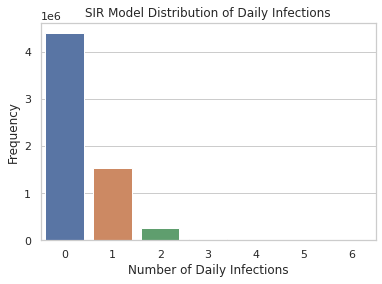

,Number of Daily Infections,Frequency,Percentage
0,0,4394137,70.858937
1,1,1524903,24.590268
2,2,253478,4.087533
3,3,26566,0.428398
4,4,2040,0.032897
5,5,115,0.001854
6,6,7,0.000113


In [12]:
sns.barplot(data = daily_infections_freq_df,
            x = "Number of Daily Infections",
            y = 'Frequency')
plt.title('SIR Model Distribution of Daily Infections')
plt.show()
daily_infections_freq_df

In [13]:
# Distribution of epidemic lengths in a trial
stats, groupby_epidemiclength, groupby_totalinfections = \
  basic_stats(trial_df, ['Epidemic_Length (Days)', 'Total_Infections'])

In [14]:
groupby_epidemiclength

Epidemic_Length (Days)
3     316112
4     108507
5     108871
6     109374
7      76040
8      64007
9      52204
10     39712
11     31738
12     24565
13     18504
14     14154
15     10499
16      7709
17      5540
18      3838
19      2871
20      1888
21      1300
22       931
23       620
24       382
25       251
26       167
27        78
28        60
29        26
30        26
31        13
32         6
33         3
34         1
35         2
38         1
Name: Epidemic_Length (Days), dtype: int64

In [15]:
# Distribution of total infections in a trial
groupby_totalinfections

Total_Infections
1     316112
2     190301
3     149798
4     111757
5      81149
6      56269
7      38051
8      24430
9      14873
10      8575
11      4521
12      2395
13      1103
14       450
15       153
16        46
17        12
18         5
Name: Total_Infections, dtype: int64

In [16]:
# Statistics per column of all the trial data
stats

,count,mean,std,min,25%,50%,75%,max
D1,1000000.0,0.379821,0.609924,0.0,0.0,0.0,1.0,5.0
D2,1000000.0,0.372042,0.603903,0.0,0.0,0.0,1.0,6.0
D3,1000000.0,0.365055,0.598106,0.0,0.0,0.0,1.0,6.0
D4,1000000.0,0.237762,0.509154,0.0,0.0,0.0,0.0,6.0
D5,1000000.0,0.194295,0.467165,0.0,0.0,0.0,0.0,5.0
D6,1000000.0,0.152432,0.420056,0.0,0.0,0.0,0.0,5.0
D7,1000000.0,0.111554,0.363494,0.0,0.0,0.0,0.0,5.0
D8,1000000.0,0.085234,0.319383,0.0,0.0,0.0,0.0,5.0
D9,1000000.0,0.063385,0.276589,0.0,0.0,0.0,0.0,5.0
D10,1000000.0,0.046526,0.238255,0.0,0.0,0.0,0.0,5.0


In [17]:
base_experiment2 = Experiment(1000000, 21, 0.03, 3)
trial_df2, daily_infections_freq_df2 = base_experiment2.run_experiment()
stats2, groupby_epidemiclength2, groupby_totalinfections2 = \
  basic_stats(trial_df2, ['Epidemic_Length (Days)', 'Total_Infections'])

Total time elapsed to gather data for 1000000 trials: 0:04:26.216361




In [18]:
trial_df2.head()

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,D33,D34,D35,D36,D37,D38,D39,D40,Epidemic_Length (Days),Total_Infections
0,1,1,0,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,8,6
1,1,0,1,1,2,1,1,1,0,0,...,0,0,0,0,0,0,0,0,18,12
2,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5,3
3,0,0,1,0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,11,5
4,1,1,1,0,0,1,1,0,0,2,...,0,0,0,0,0,0,0,0,27,17


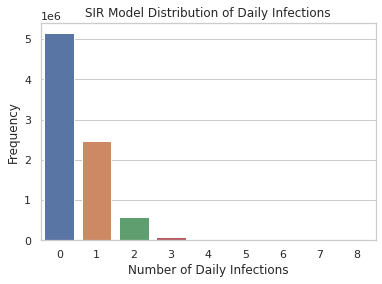

,Number of Daily Infections,Frequency,Percentage
0,0,5143939,62.117605
1,1,2464297,29.758562
2,2,575705,6.952146
3,3,86705,1.047039
4,4,9497,0.114685
5,5,776,0.009371
6,6,44,0.000531
7,7,4,0.000048
8,8,1,0.000012


In [19]:
sns.barplot(data = daily_infections_freq_df2,
            x = "Number of Daily Infections",
            y = 'Frequency')
plt.title('SIR Model Distribution of Daily Infections')
plt.show()
daily_infections_freq_df2

In [20]:
groupby_epidemiclength2

Epidemic_Length (Days)
3     176580
4      87199
5      89333
6      92453
7      79396
8      72759
9      65458
10     57796
11     50320
12     43451
13     36948
14     31452
15     25831
16     21306
17     17048
18     13446
19     10450
20      8042
21      5971
22      4492
23      3180
24      2274
25      1600
26      1156
27       728
28       497
29       341
30       202
31       111
32        85
33        34
34        19
35        17
36        18
37         4
38         2
40         1
Name: Epidemic_Length (Days), dtype: int64

In [21]:
groupby_totalinfections2

Total_Infections
1     176580
2     119322
3     116587
4     108495
5      97673
6      86873
7      74795
8      61936
9      49135
10     37831
11     27286
12     18582
13     11873
14      6911
15      3558
16      1629
17       694
18       190
19        41
20         9
Name: Total_Infections, dtype: int64

In [22]:
stats2

,count,mean,std,min,25%,50%,75%,max
D1,1000000.0,0.569674,0.744009,0.0,0.0,0.0,1.0,8.0
D2,1000000.0,0.552325,0.732263,0.0,0.0,0.0,1.0,7.0
D3,1000000.0,0.536725,0.721217,0.0,0.0,0.0,1.0,6.0
D4,1000000.0,0.419606,0.667153,0.0,0.0,0.0,1.0,6.0
D5,1000000.0,0.359771,0.629845,0.0,0.0,0.0,1.0,6.0
D6,1000000.0,0.304048,0.588997,0.0,0.0,0.0,0.0,6.0
D7,1000000.0,0.249371,0.540503,0.0,0.0,0.0,0.0,6.0
D8,1000000.0,0.204351,0.495471,0.0,0.0,0.0,0.0,5.0
D9,1000000.0,0.165817,0.449339,0.0,0.0,0.0,0.0,6.0
D10,1000000.0,0.131701,0.403388,0.0,0.0,0.0,0.0,6.0


## Data Viz

In [23]:
#!pip install -U matplotlib

In [36]:
def long(df, pop_size):
  """
  This function takes the output df from run_experiment()
  and cleans and transforms data for epidimiological graphing.
  The df is melted to a long form on the variables, simulation and day.
  Additional variable created include cummulative totals for infections, 
  recovered agents, and susceptible agents.

  Params:
    df: Pandas dataframe,
    pop_size: Size of population as an integer.

  Returns: 
    Pandas dataframe melted and transformed.
  """
  #cleaning original df
  long_df = df.copy()
  long_df.drop(columns=long_df.columns[-2:], axis=1,  inplace=True)
  long_df.reset_index(inplace=True)

  #creating simulation column
  long_df = long_df.rename(columns = {'index':'simulation'}) 

  #melting on simulation and day
  long_df = long_df.melt(id_vars=['simulation'], 
                         var_name = "day", 
                         value_name = "daily infections")
  #removing "D" from day values
  long_df['day'] = long_df["day"].map(lambda x: x.lstrip('D')).astype(int)

  #creating cumulative sum of infections for each day
  long_df['daily infections'] = long_df['daily infections'].astype(int)
  long_df = long_df.sort_values(["simulation", "day"])
  long_df['total infections'] = long_df.groupby(['simulation'])\
    ['daily infections'].cumsum().astype(int)
   
  #creating cumulative sum of recovered agents for each day
  long_df['recovered'] = long_df['total infections'].shift(
      3, axis = 0, fill_value = 0).astype(int)
  long_df.loc[long_df.day == 1, 'recovered'] = 0
  long_df.loc[long_df.day == 2, 'recovered'] = 0
  long_df.loc[long_df.day == 3, 'recovered'] = 0

  #creating susceptible value for each day
  long_df['susceptible'] = pop_size - long_df['total infections']
  long_df = long_df.sort_values(["simulation", "day"])


# creating value for prevalence
  long_df['prevalence'] = long_df['daily infections']/pop_size

  return long_df


def epidimiological_experiment(num_trials, 
                                      pop_size, 
                                      p_exposure, 
                                      infection_period):
  """
  Run experiments and conduct epidimiological analysis.

  Params:
    num_trials: Number of trials to conduct.
    pop_size: Size of population as an integer.
    p_exposure: Probability of catching the virus as a float, in range[0,1]; 
      can be a float or a 2-tuple of floats to indicate variation.
    infection_period: Amount of time in days a person is infectious;
      can be an integer or a 2-tuple of integers to indicate variation.

  Returns:
    6-tuple of Pandas Dataframes:
      trial data,
      daily infections,
      trial data melted and transformed,
      stats of the melted and transformed trial data,
      mean (or expected) values for each day,
      trial data melted and transformed, and then melted again
  """
  df, daily_infections_freq_df = Experiment(num_trials,
                                            pop_size,
                                            p_exposure,
                                            infection_period).run_experiment()
  long_df = long(df, pop_size)
  stats_df = long_df.describe()
  stats_df.drop(stats_df.columns[[0, 1]], axis=1, inplace=True)
  stats_df = stats_df.join(df['Epidemic_Length (Days)'].describe())
  mean_df = long_df.groupby(['day'])['daily infections',
                                     'total infections',
                                     'recovered',
                                     'susceptible',
                                     'prevalence'].mean()
  sir_df = long_df.melt(
    id_vars=['simulation', 'day'],
    value_vars = ["total infections", "recovered", "susceptible"]
  )
  return df, daily_infections_freq_df, long_df, stats_df, mean_df, sir_df


def plot_SIR_distribution_epidemic_length(df):
  """
  Plot SIR Model Distribution of Epidemic Length

  Params:
    df: Pandas Dataframe of trial data
  """
  sns.histplot(data = df, x = "Epidemic_Length (Days)", kde =True, bins = 10)
  plt.title('SIR Model Distribution of Epidemic Length')
  plt.show()


def plot_SIR_distribution_incidence(df):
  """
  Plot SIR Model Distribution of Incidence

  Params:
    df: Pandas Dataframe of Daily Infections
  """
  sns.barplot(data = df,
              x = "Number of Daily Infections",
              y = 'Frequency')
  plt.title('SIR Model Distribution of Incidence')
  plt.show()


def plot_SIR_distribution_infection_totals(df, bins=10):
  """
  Plot SIR Model Distribution of Infection Totals

  Params:
    df: Pandas Dataframe
    bins: number of bins, uses 10 bins by default
  """
  sns.histplot(data = df, x = "total infections", bins = bins)
  plt.title('SIR Model Distribution of Infection Totals')
  plt.show()


def plot_SIR_timeseries(df):
  """
  Plot SIR timeseries of Susceptible, Infectious, and Recovery values

  Params:
    df: Pandas Dataframe
  """
  sns.lineplot(x = "day", y = "value", data = df, hue = "variable")
  plt.ylabel('Number of People')
  plt.title('SIR Model')
  plt.show()


def plot_lineplot_epidimiology(df, x, y, title):
  """
  Plot SIR Lineplot

  Params:
    df: Pandas Dataframe
    x: df column on x-axis.
    y: df column on y-axis.
    title: Title of the plot.
  """
  sns.lineplot(x = x, y = y, data = df)
  plt.title(title)
  plt.show()


def plot_distribution_total_infections_by_day(df):
  """
  Plot Distibution of Total Infections by Day

  Params:
    df: Pandas Dataframe
  """
  fig, ax = plt.subplots(figsize=(15,4))
  sns.boxenplot(data = df , 
                x = "day", 
                y = "total infections")
  plt.title('Distibution of Total Infections by Day')
  plt.show()

In [37]:
epidim_10k = epidimiological_experiment(10000, 21, 0.02, 3)
df10k, dailyinfectionsfreqdf10k, longdf10k, statsdf10k, meandf10k, sirdf10k = \
  epidim_10k

Total time elapsed to gather data for 10000 trials: 0:00:01.934456




<ipython-input-36-69a998a5ed61>:87: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mean_df = long_df.groupby(['day'])['daily infections',


In [38]:
longdf10k

,simulation,day,daily infections,total infections,recovered,susceptible,prevalence
0,0,1,0,0,0,21,0.000000
10000,0,2,0,0,0,21,0.000000
20000,0,3,1,1,0,20,0.047619
30000,0,4,2,3,0,18,0.095238
40000,0,5,1,4,0,17,0.047619
...,...,...,...,...,...,...,...
229999,9999,23,0,3,3,18,0.000000
239999,9999,24,0,3,3,18,0.000000
249999,9999,25,0,3,3,18,0.000000
259999,9999,26,0,3,3,18,0.000000


In [39]:
# table for descriptive statistics
statsdf10k

,daily infections,total infections,recovered,susceptible,prevalence,Epidemic_Length (Days)
count,270000.000000,270000.000000,270000.000000,270000.000000,270000.000000,10000.000000
mean,0.079300,1.881170,1.643270,19.118830,0.003776,6.222200
std,0.314932,2.077288,2.012478,2.077288,0.014997,3.632815
min,0.000000,0.000000,0.000000,7.000000,0.000000,3.000000
25%,0.000000,0.000000,0.000000,18.000000,0.000000,3.000000
50%,0.000000,1.000000,1.000000,20.000000,0.000000,5.000000
75%,0.000000,3.000000,3.000000,21.000000,0.000000,8.000000
max,5.000000,14.000000,14.000000,21.000000,0.238095,27.000000


In [40]:
# table of mean (or expected) values for each day
meandf10k.head()

,daily infections,total infections,recovered,susceptible,prevalence
day,,,,,
1,0.3799,0.3799,0.0000,20.6201,0.018090
2,0.3727,0.7526,0.0000,20.2474,0.017748
3,0.3701,1.1227,0.0000,19.8773,0.017624
4,0.2418,1.3645,0.3799,19.6355,0.011514
5,0.1943,1.5588,0.7526,19.4412,0.009252


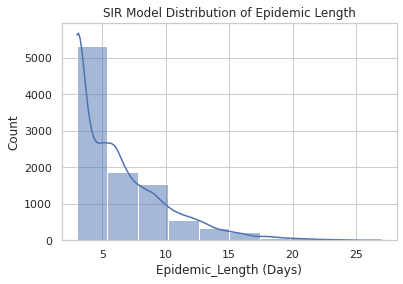

In [41]:
plot_SIR_distribution_epidemic_length(df10k)

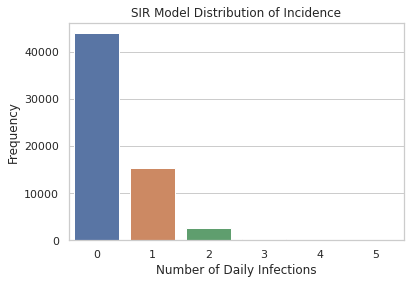

,Number of Daily Infections,Frequency,Percentage
0,0,43990,70.698467
1,1,15379,24.716338
2,2,2553,4.103050
3,3,276,0.443573
4,4,22,0.035357
5,5,2,0.003214


In [42]:
plot_SIR_distribution_incidence(dailyinfectionsfreqdf10k)
dailyinfectionsfreqdf10k

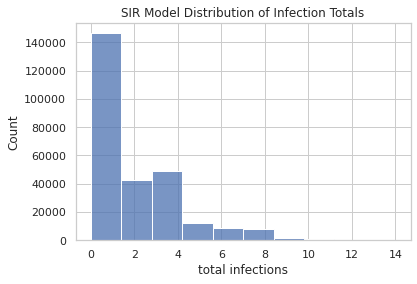

In [43]:
plot_SIR_distribution_infection_totals(longdf10k)

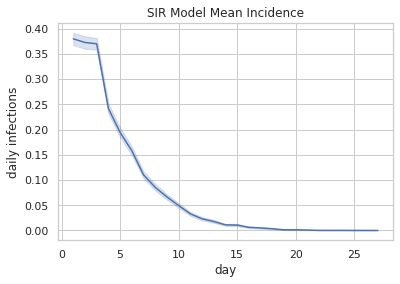

In [44]:
plot_lineplot_epidimiology(longdf10k, 
                           x="day", y="daily infections", 
                           title='SIR Model Mean Incidence')

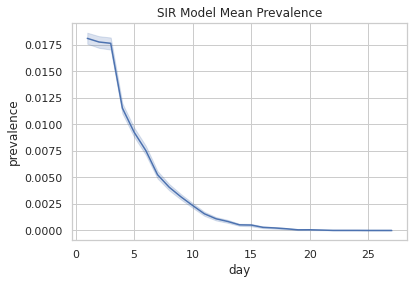

In [45]:
plot_lineplot_epidimiology(longdf10k, 
                           x="day", y="prevalence", 
                           title='SIR Model Mean Prevalence')

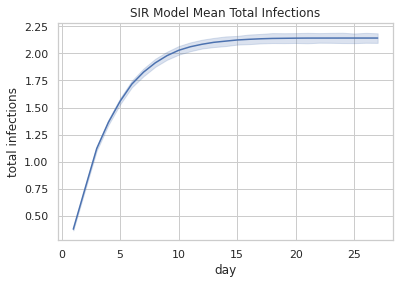

In [46]:
plot_lineplot_epidimiology(longdf10k, 
                           x="day", y="total infections", 
                           title='SIR Model Mean Total Infections')

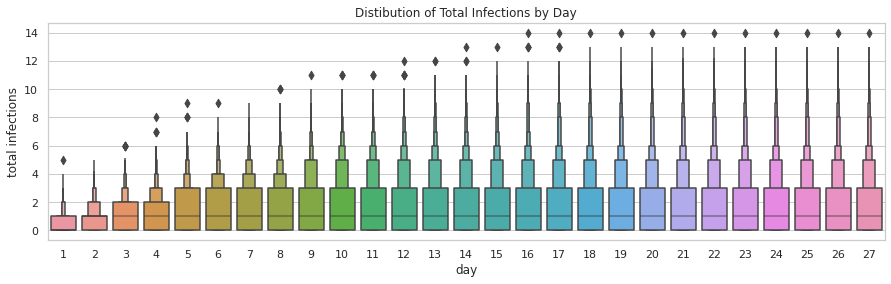

In [47]:
plot_distribution_total_infections_by_day(longdf10k)

In [48]:
sirdf10k

,simulation,day,variable,value
0,0,1,total infections,0
1,0,2,total infections,0
2,0,3,total infections,1
3,0,4,total infections,3
4,0,5,total infections,4
...,...,...,...,...
809995,9999,23,susceptible,18
809996,9999,24,susceptible,18
809997,9999,25,susceptible,18
809998,9999,26,susceptible,18


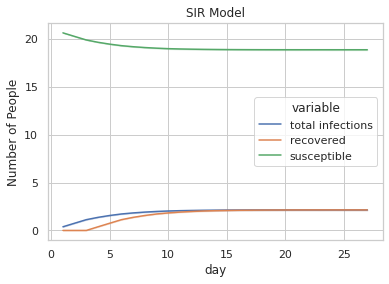

In [49]:
plot_SIR_timeseries(sirdf10k)

### Plotting each simulation

In [50]:
def plot_sim_daily_infections(df):
  """
  Plot simulations' daily infections

  Params:
    df: Pandas Dataframe of Simulations
  """
  plt = sns.lineplot(data = df, x = "day", y = "daily infections", 
                     hue = "simulation")
  plt.xaxis.set_major_locator(ticker.MultipleLocator(10))


def plot_sim_total_infections(df):
  """
  Plot simulations' total infections

  Params:
    df: Pandas Dataframe of Simulations
  """
  plt = sns.lineplot(data = df, x = "day", y = "total infections", 
                     hue = "simulation")
  plt.xaxis.set_major_locator(ticker.MultipleLocator(10))



In [51]:
experiment_100 = Experiment(100, 200, 0.02, 3)
_,_,longdf100,_,_,_ = epidimiological_experiment(
    100, 
    200, 
    0.02, 
    3
)

Total time elapsed to gather data for 100 trials: 0:00:00.348087




<ipython-input-36-69a998a5ed61>:87: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mean_df = long_df.groupby(['day'])['daily infections',


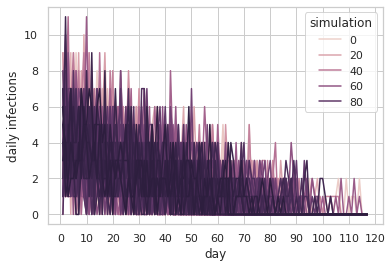

In [52]:
plot_sim_daily_infections(longdf100)

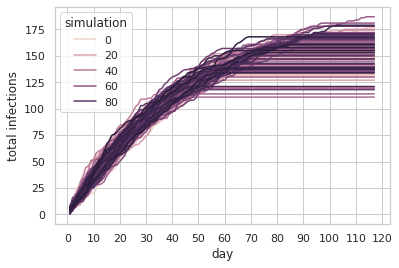

In [53]:
plot_sim_total_infections(longdf100)

## Additional Analysis
This section includes:

* Effect of varied infection probability
* Effect of varied infection length
* Effect of varied class size


In [54]:
import matplotlib.pyplot as plt
def coupled_experiments(params, epi_len, dfs, index, val):
  """
  Run a set of experiments and update epidemic lengths and dfs passed by ref.

  Params:
    params: tuple of parameters for Experiment.
    epi_len: Pandas dataframe of epidemic lengths.
    dfs: Dictionary of Pandas dataframes.
    index: integer index as key for entry into dfs.
    val: value of a variable which to assess its effects on.
  """
  expdf, daily_infection_freq_expdf = Experiment(*params).run_experiment()
  epi_len[str(val)] = expdf[["Epidemic_Length (Days)"]]
  dfs[index] = long(expdf, params[1])


def data_varying_infection_probs(infection_probs, num_trials, 
                                 pop_size, infection_period):
  """
  Visualize the effect of varying infection probabilities in epidemic.

  Params:
    infection_probs: list of infection probabilities.

  Returns:
    2-tuple of Epidemic Lengths dataframe and Dictionary of Pandas dataframes.
  """
  prob_dfs = {}
  epi_len = pd.DataFrame()
  for i,p in enumerate(infection_probs):
    coupled_experiments(
        (num_trials, pop_size, p, infection_period),
        epi_len,
        prob_dfs,
        i,
        p
    )
  epi_len.reset_index(inplace=True)
  epi_len = epi_len.rename(columns = {'index':'simulation'})
  epi_len = epi_len.melt(id_vars=['simulation'], 
                         var_name = "infection probability", 
                         value_name = "length of epidemic")
  return epi_len, prob_dfs


def data_varying_effect_infection_lengths(infection_lengths, num_trials, 
                                          pop_size, p_exposure):
  """
  Visualize the effect of varying infection length in epidemic.

  Params:
    infection_lengths: list of infection period lengths.

  Returns:
    2-tuple of Epidemic Lengths dataframe and Dictionary of Pandas dataframes.
  """
  #infection_lengths = [1,2,3,4,5]
  l_dfs = {}
  epi_len2 = pd.DataFrame()
  for i,l in enumerate(infection_lengths):
    coupled_experiments(
        (num_trials, pop_size, p_exposure, l),
        epi_len2,
        l_dfs,
        i,
        l
    )
  epi_len2.reset_index(inplace=True)
  epi_len2 = epi_len2.rename(columns = {'index':'simulation'})
  epi_len2 = epi_len2.melt(id_vars=['simulation'], 
                           var_name = "infection length", 
                           value_name = "length of epidemic")
  return epi_len2, l_dfs


def data_varying_effect_class_size(class_size, num_trials, p_exposure, 
                                   infection_period):
  """
  Visualize the effect of varying class size.

  Params:
    class_size: list of class size.

  Returns:
    2-tuple of Epidemic Lengths dataframe and Dictionary of Pandas dataframes
  """
  #class_size = [*range(10, 101, 10)]
  c_dfs = {}
  epi_len3 = pd.DataFrame()
  for i,c in enumerate(class_size):
    coupled_experiments(
        (num_trials, c, p_exposure, infection_period),
        epi_len3,
        c_dfs,
        i,
        c
    )
  epi_len3.reset_index(inplace=True)
  epi_len3 = epi_len3.rename(columns = {'index':'simulation'})
  epi_len3 = epi_len3.melt(id_vars=['simulation'], 
                           var_name = "class size", 
                           value_name = "length of epidemic")
  return epi_len3, c_dfs


def run_variation_analysis(num_trials, pop_size, p_exposure, infection_period):
  """
  Run experiments with one of the key parameters as a list.

  Params:
    num_trials: Must be an integer.
    pop_size: Can be either an integer or a list of integers.
    p_exposure: can be either a float or a list of floats.
    infection_period: can be either an integer or a list of integers.

  Returns:
    2-tuple of Epidemic Lengths dataframe and Dictionary of Pandas dataframes
  """
  if not isinstance(num_trials, int):
    raise ValueError("num_trials must be an integer!")
  if (isinstance(pop_size, list), 
      isinstance(p_exposure, (float, tuple)), 
      isinstance(infection_period, (int, tuple))) == (True, True, True):
      return data_varying_effect_class_size(
          pop_size, 
          num_trials, 
          p_exposure, 
          infection_period
      )
  if (isinstance(pop_size, int), 
      isinstance(p_exposure, list), 
      isinstance(infection_period, (int, tuple))) == (True, True, True):
      return data_varying_infection_probs(
          p_exposure, 
          num_trials, 
          pop_size,
          infection_period
      )
  if (isinstance(pop_size, int), 
      isinstance(p_exposure, (float, tuple)), 
      isinstance(infection_period, list)) == (True, True, True):
      return data_varying_effect_infection_lengths(
          infection_period, 
          num_trials,
          pop_size, 
          p_exposure
      )
  raise RuntimeError(
      "Check your inputs into this function and try again!"
      "Hint: num_trials must always be a int; as for the rest of the variables,"
      " only one of them can be a list!"
  )


def graph_against_epidemic_lengths(epi_len, x, hue_quantity, bins):
  """
  Graph against epidemic lengths.

  Params:
    epi_len: Pandas dataframe of epidemic lengths.
    x: x-axis label.
    hue_quantity: hue property which is also the quantity of interest.
    bins: Number of bins.
  """
  fig, ax =plt.subplots(1,2)
  sns.histplot(data = epi_len, x = x, hue = hue_quantity, bins = bins, ax=ax[0])
  sns.histplot(data = epi_len, x = x, hue = hue_quantity, 
               bins = bins, element = "poly", ax=ax[1])
  fig.set_size_inches(15, 4)
  fig.suptitle(f'Distibution of Epidemic Lengths by {hue_quantity}')


def graph_against_infection_counts(vals, dfs, x, y1, y2, 
                                   label, quantity, legend=None):
  """
  Graph against infection counts.

  Params:
    vals: list of values.
    dfs: Dictionary of Pandas dataframes.
    x: x-axis label.
    y1: y-axis label for first graph.
    y2: y-axis label for second graph.
    label: legend label.
    quantity: actual variable of interest.
    legend: Legend parameter; default to None as parameter is optional.
  """
  fig, ax = plt.subplots(1,2)
  for i,v in enumerate(vals):
    sns.lineplot(x = x, y = y1, data = dfs[i], 
                 label =f'{label} = {v}', ax=ax[0])
    sns.lineplot(x = x, y = y2, data = dfs[i], 
                 label =f'{label} = {v}', ax=ax[1])
  fig.set_size_inches(15, 4)
  fig.suptitle(f'Incidence and Total Infections by {quantity}')
  if legend:
    fig.legend(title = legend)

### Varied Infection probability
$N = 21$, $\text{infection period (days)} = 3$

In [55]:
p_exposures = [.01, .05, .1, .25, .5, .75]
epi_len1, prob_dfs = run_variation_analysis(10000, 21, p_exposures, 3)

Total time elapsed to gather data for 10000 trials: 0:00:01.338983


Total time elapsed to gather data for 10000 trials: 0:00:04.177507


Total time elapsed to gather data for 10000 trials: 0:00:05.900091


Total time elapsed to gather data for 10000 trials: 0:00:06.600322


Total time elapsed to gather data for 10000 trials: 0:00:06.029311


Total time elapsed to gather data for 10000 trials: 0:00:05.891882




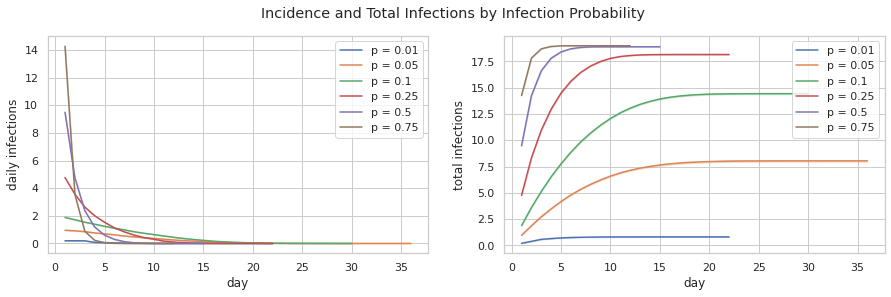

In [56]:
graph_against_infection_counts(p_exposures, 
                               prob_dfs,
                               "day",
                               "daily infections",
                               "total infections",
                               'p',
                               'Infection Probability')
#plt.savefig('inf_prob.png')

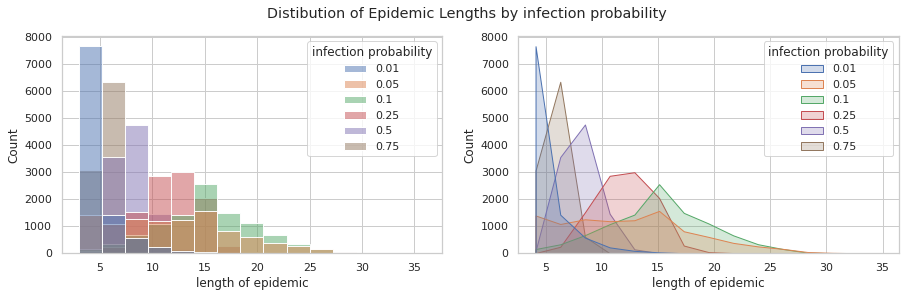

In [57]:
graph_against_epidemic_lengths(epi_len1,
                               "length of epidemic",
                               "infection probability",
                               15)
#plt.savefig('inf_prob_epi_len.png')

### Varied Infection Length

$N=21$, $p=0.02$

In [58]:
infection_periods = [1,2,3,4,5]
epi_len2, l_dfs = run_variation_analysis(10000, 21, 0.02, infection_periods)

Total time elapsed to gather data for 10000 trials: 0:00:00.653344


Total time elapsed to gather data for 10000 trials: 0:00:01.137927


Total time elapsed to gather data for 10000 trials: 0:00:01.831025


Total time elapsed to gather data for 10000 trials: 0:00:02.774440


Total time elapsed to gather data for 10000 trials: 0:00:03.911596




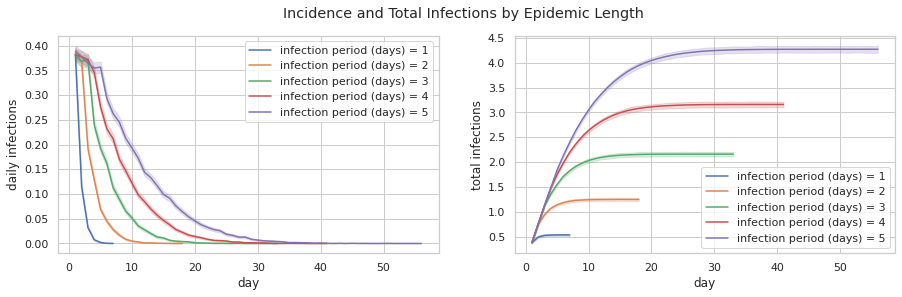

In [59]:
graph_against_infection_counts(infection_periods, 
                               l_dfs,
                               "day",
                               "daily infections",
                               "total infections",
                               'infection period (days)',
                               'Epidemic Length')
#plt.savefig('inf_len.png')

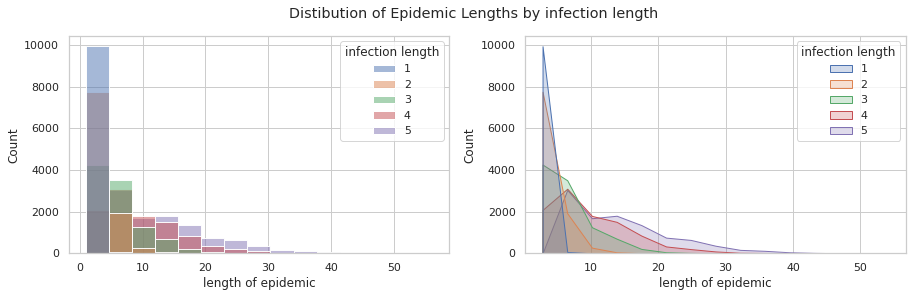

In [60]:
graph_against_epidemic_lengths(epi_len2,
                               "length of epidemic",
                               "infection length",
                               15)
#plt.savefig('inf_len_epi_len.png')

### Varied Class Size

$p=0.02$, $\text{infection period (days)} = 3$

In [61]:
pop_sizes = [*range(10, 101, 10)]
epi_len3, c_dfs = run_variation_analysis(10000, pop_sizes, 0.02, 3)

Total time elapsed to gather data for 10000 trials: 0:00:01.222814


Total time elapsed to gather data for 10000 trials: 0:00:01.878706


Total time elapsed to gather data for 10000 trials: 0:00:02.535489


Total time elapsed to gather data for 10000 trials: 0:00:03.641057


Total time elapsed to gather data for 10000 trials: 0:00:05.379534


Total time elapsed to gather data for 10000 trials: 0:00:06.941050


Total time elapsed to gather data for 10000 trials: 0:00:08.356687


Total time elapsed to gather data for 10000 trials: 0:00:10.094668


Total time elapsed to gather data for 10000 trials: 0:00:13.168703


Total time elapsed to gather data for 10000 trials: 0:00:13.896813




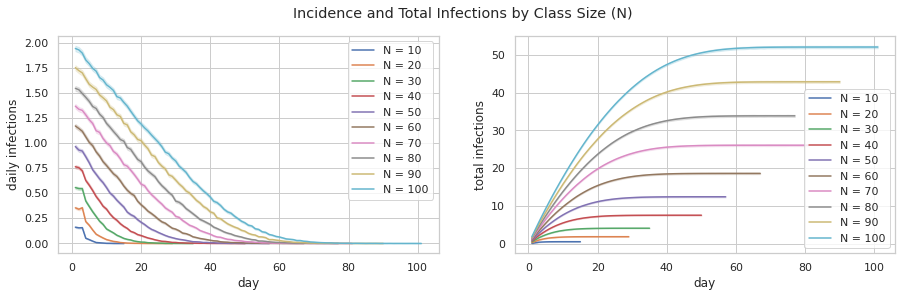

In [62]:
graph_against_infection_counts(pop_sizes, 
                               c_dfs,
                               "day",
                               "daily infections",
                               "total infections",
                               'N',
                               "Class Size (N)")
#plt.savefig('class_size.png')

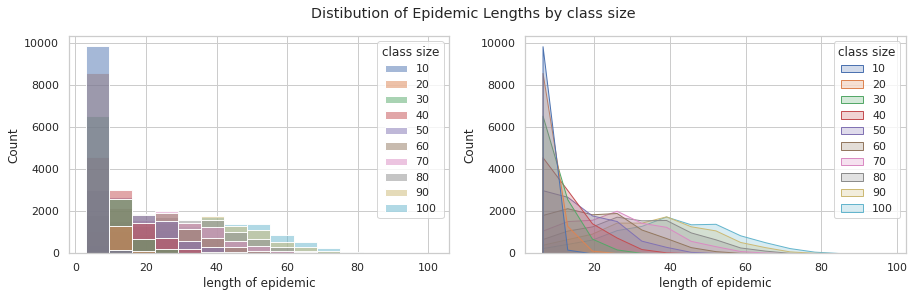

In [63]:
graph_against_epidemic_lengths(epi_len3,
                               "length of epidemic",
                               "class size",
                               15)
#plt.savefig('class_size_epi_len.png')

### Correlation for All Vars on Epidemic Length

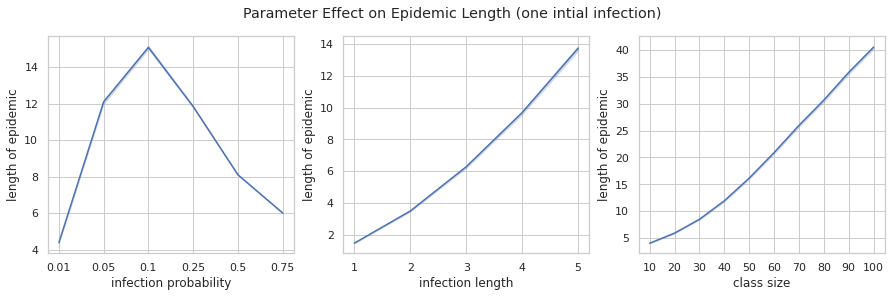

In [64]:
fig, axs = plt.subplots(ncols = 3)
sns.lineplot(data = epi_len1, 
             x = "infection probability", 
             y = "length of epidemic", 
             ax = axs[0])
sns.lineplot(data = epi_len2, 
             x = "infection length", 
             y = "length of epidemic", 
             ax = axs[1])
sns.lineplot(data = epi_len3, 
             x = "class size", 
             y = "length of epidemic", 
             ax = axs[2])
fig.set_size_inches(15, 4)
fig.suptitle('Parameter Effect on Epidemic Length (one intial infection)')
plt.savefig('all_vars_epi_len.png')

## Bonus Content on Future Work

### An Experiment involving Varying Infection Periods

In [65]:
bonus_experiment = Experiment(1000000, 21, 0.02, (3,7))
bonus_trial_df, bonus_infections_freq_df = bonus_experiment.run_experiment()
bonus_stats, bonus_groupby_epidemiclength, bonus_groupby_totalinfections = \
  basic_stats(bonus_trial_df, ['Epidemic_Length (Days)', 'Total_Infections'])

Total time elapsed to gather data for 1000000 trials: 0:06:06.725886




In [66]:
bonus_trial_df

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,D52,D53,D54,D55,D56,D57,D58,D59,Epidemic_Length (Days),Total_Infections
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,7,2
1,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,10,3
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,6,2
3,1,0,0,1,1,0,0,3,0,1,...,0,0,0,0,0,0,0,0,16,8
4,3,1,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,26,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,1,0,1,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,11,5
999996,0,2,0,0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,31,12
999997,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,6,2
999998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,6,1


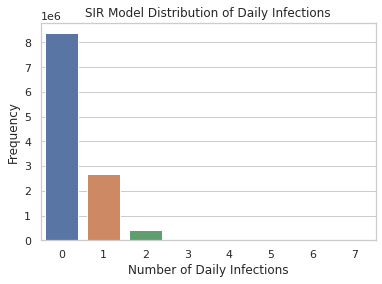

,Number of Daily Infections,Frequency,Percentage
0,0,8373183,72.716161
1,1,2678463,23.260873
2,2,417956,3.629702
3,3,42168,0.366204
4,4,2947,0.025593
5,5,164,0.001424
6,6,4,0.000035
7,7,1,0.000009


In [67]:
sns.barplot(data = bonus_infections_freq_df,
            x = "Number of Daily Infections",
            y = 'Frequency')
plt.title('SIR Model Distribution of Daily Infections')
plt.show()
bonus_infections_freq_df

In [68]:
bonus_groupby_epidemiclength

Epidemic_Length (Days)
3     78764
4     65075
5     68485
6     83503
7     62711
8     60550
9     58474
10    54672
11    51176
12    46996
13    43107
14    39978
15    36119
16    32683
17    28993
18    26442
19    23293
20    20553
21    18290
22    15771
23    13713
24    11995
25    10246
26     8569
27     7378
28     6227
29     5159
30     4176
31     3451
32     2890
33     2268
34     1847
35     1374
36     1195
37      944
38      737
39      554
40      425
41      342
42      253
43      162
44      132
45      108
46       70
47       53
48       25
49       19
50       19
51       15
52        7
53        6
54        1
55        2
56        1
59        2
Name: Epidemic_Length (Days), dtype: int64

In [69]:
bonus_groupby_totalinfections

Total_Infections
1     193761
2     133789
3     119181
4     107998
5      95908
6      83696
7      70436
8      57373
9      44727
10     33202
11     23613
12     15831
13      9960
14      5659
15      2871
16      1292
17       528
18       137
19        31
20         7
Name: Total_Infections, dtype: int64

In [70]:
bonus_stats

,count,mean,std,min,25%,50%,75%,max
D1,1000000.0,0.379891,0.609751,0.0,0.0,0.0,1.0,6.0
D2,1000000.0,0.372873,0.604802,0.0,0.0,0.0,1.0,7.0
D3,1000000.0,0.365238,0.598077,0.0,0.0,0.0,1.0,5.0
D4,1000000.0,0.328740,0.577277,0.0,0.0,0.0,1.0,6.0
D5,1000000.0,0.296895,0.553804,0.0,0.0,0.0,1.0,5.0
...,...,...,...,...,...,...,...,...
D57,1000000.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
D58,1000000.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
D59,1000000.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
Epidemic_Length (Days),1000000.0,11.514886,7.063331,3.0,6.0,10.0,16.0,59.0


### An Experiment involving Varying Infection Probabilities

In [71]:
bonus_experiment2 = Experiment(1000000, 21, (0.05,0.15), 3)
bonus_trial_df2, bonus_daily_infections_freq_df2 = \
  bonus_experiment2.run_experiment()
bonus_stats2, bonus_groupby_epidemiclength2, bonus_groupby_totalinfections2 = \
  basic_stats(bonus_trial_df2, ['Epidemic_Length (Days)', 'Total_Infections'])

Total time elapsed to gather data for 1000000 trials: 0:12:12.963162




In [72]:
bonus_trial_df2

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,D28,D29,D30,D31,D32,D33,D34,D35,Epidemic_Length (Days),Total_Infections
0,0,0,4,2,1,0,3,2,3,0,...,0,0,0,0,0,0,0,0,14,17
1,2,4,0,1,0,3,2,2,2,1,...,0,0,0,0,0,0,0,0,13,18
2,1,0,3,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,8,6
3,2,1,3,1,3,1,0,3,0,0,...,0,0,0,0,0,0,0,0,16,18
4,0,3,4,1,2,1,0,1,0,0,...,0,0,0,0,0,0,0,0,22,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,2,6,2,2,3,0,0,1,0,1,...,0,0,0,0,0,0,0,0,13,18
999996,1,0,3,1,3,1,1,0,2,1,...,0,0,0,0,0,0,0,0,16,18
999997,2,1,7,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,7,12
999998,2,3,3,1,2,0,1,0,0,2,...,0,0,0,0,0,0,0,0,18,18


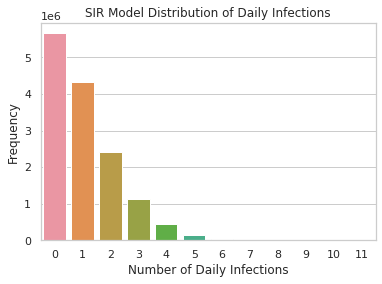

,Number of Daily Infections,Frequency,Percentage
0,0,5660487,40.020683
1,1,4313986,30.500674
2,2,2419354,17.105277
3,3,1126331,7.963367
4,4,435134,3.076477
5,5,140217,0.991360
6,6,37958,0.268370
7,7,8471,0.059892
8,8,1672,0.011821
9,9,257,0.001817


In [73]:
sns.barplot(data = bonus_daily_infections_freq_df2,
            x = "Number of Daily Infections",
            y = 'Frequency')
plt.title('SIR Model Distribution of Daily Infections')
plt.show()
bonus_daily_infections_freq_df2

In [74]:
bonus_groupby_epidemiclength2

Epidemic_Length (Days)
3       8742
4       2778
5       3938
6       8095
7      16118
8      28403
9      44628
10     62006
11     79271
12     92111
13    100167
14    101330
15     96739
16     86582
17     73234
18     58691
19     45123
20     33078
21     22680
22     14819
23      9355
24      5437
25      3196
26      1692
27       925
28       450
29       210
30       109
31        49
32        23
33        18
34         2
35         1
Name: Epidemic_Length (Days), dtype: int64

In [75]:
bonus_groupby_totalinfections2

Total_Infections
1       8742
2       1995
3       1612
4       1457
5       1727
6       2352
7       3333
8       5089
9       7963
10     12365
11     19156
12     29027
13     44775
14     66207
15     94899
16    128926
17    161030
18    177222
19    153370
20     78753
Name: Total_Infections, dtype: int64

In [76]:
bonus_stats2

,count,mean,std,min,25%,50%,75%,max
D1,1000000.0,1.901731,1.411921,0.0,1.0,2.0,3.0,11.0
D2,1000000.0,1.993314,1.384432,0.0,1.0,2.0,3.0,10.0
D3,1000000.0,1.904644,1.326166,0.0,1.0,2.0,3.0,10.0
D4,1000000.0,1.699631,1.258603,0.0,1.0,2.0,2.0,10.0
D5,1000000.0,1.477196,1.185103,0.0,1.0,1.0,2.0,10.0
D6,1000000.0,1.263880,1.107732,0.0,0.0,1.0,2.0,10.0
D7,1000000.0,1.069751,1.030494,0.0,0.0,1.0,2.0,8.0
D8,1000000.0,0.895094,0.953677,0.0,0.0,1.0,1.0,7.0
D9,1000000.0,0.737517,0.877809,0.0,0.0,1.0,1.0,7.0
D10,1000000.0,0.600109,0.802914,0.0,0.0,0.0,1.0,9.0


### An Experiment involving both Varying Infection Probabilities and Periods

In [77]:
bonus_experiment3 = Experiment(1000000, 21, (0.05,0.15), (3,7))
bonus_trial_df3, bonus_daily_infections_freq_df3 = \
  bonus_experiment3.run_experiment()
bonus_stats3, bonus_groupby_epidemiclength3, bonus_groupby_totalinfections3 = \
  basic_stats(bonus_trial_df3, ['Epidemic_Length (Days)', 'Total_Infections'])

Total time elapsed to gather data for 1000000 trials: 0:17:39.026572




In [78]:
bonus_trial_df3

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,D38,D39,D40,D41,D42,D43,D44,D45,Epidemic_Length (Days),Total_Infections
0,0,0,1,5,2,1,3,1,0,1,...,0,0,0,0,0,0,0,0,24,20
1,1,0,2,2,2,0,3,2,1,0,...,0,0,0,0,0,0,0,0,27,20
2,2,5,2,0,2,1,1,1,2,0,...,0,0,0,0,0,0,0,0,15,17
3,3,1,2,4,3,2,0,1,0,1,...,0,0,0,0,0,0,0,0,13,18
4,4,2,3,1,0,2,2,1,1,0,...,0,0,0,0,0,0,0,0,16,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,2,2,4,1,4,0,2,1,0,0,...,0,0,0,0,0,0,0,0,18,18
999996,1,5,1,3,2,0,1,0,2,1,...,0,0,0,0,0,0,0,0,15,18
999997,0,2,4,0,3,0,0,3,1,1,...,0,0,0,0,0,0,0,0,19,20
999998,3,1,4,0,2,2,0,0,1,0,...,0,0,0,0,0,0,0,0,17,17


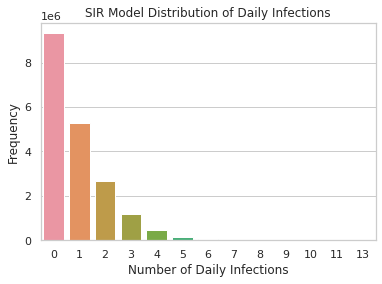

,Number of Daily Infections,Frequency,Percentage
0,0,9323577,48.716853
1,1,5296823,27.676561
2,2,2668658,13.944071
3,3,1197971,6.259548
4,4,455939,2.382338
5,5,145868,0.762178
6,6,38698,0.202202
7,7,8753,0.045736
8,8,1671,0.008731
9,9,292,0.001526


In [79]:
sns.barplot(data = bonus_daily_infections_freq_df3,
            x = "Number of Daily Infections",
            y = 'Frequency')
plt.title('SIR Model Distribution of Daily Infections')
plt.show()
bonus_daily_infections_freq_df3

In [80]:
bonus_groupby_epidemiclength3

Epidemic_Length (Days)
3      2200
4       801
5       394
6       347
7       409
8      1139
9      3123
10     7555
11    15093
12    25769
13    38869
14    53664
15    66895
16    78005
17    85216
18    88697
19    87288
20    82124
21    74747
22    64884
23    55057
24    44583
25    34753
26    26530
27    19897
28    14136
29     9674
30     6612
31     4392
32     2751
33     1738
34     1145
35      645
36      392
37      216
38      122
39       63
40       33
41       22
42       10
43        7
44        2
45        1
Name: Epidemic_Length (Days), dtype: int64

In [81]:
bonus_groupby_totalinfections3

Total_Infections
1       3045
2        439
3        203
4        137
5        152
6        155
7        248
8        404
9        771
10      1341
11      2678
12      5201
13     10400
14     20271
15     38635
16     71830
17    126413
18    204407
19    274400
20    238870
Name: Total_Infections, dtype: int64

In [82]:
bonus_stats3

,count,mean,std,min,25%,50%,75%,max
D1,1000000.0,1.899583,1.414261,0.0,1.0,2.0,3.0,13.0
D2,1000000.0,1.992461,1.383155,0.0,1.0,2.0,3.0,11.0
D3,1000000.0,1.907672,1.325248,0.0,1.0,2.0,3.0,10.0
D4,1000000.0,1.731204,1.261932,0.0,1.0,2.0,2.0,10.0
D5,1000000.0,1.533642,1.193929,0.0,1.0,1.0,2.0,9.0
D6,1000000.0,1.339099,1.123692,0.0,0.0,1.0,2.0,9.0
D7,1000000.0,1.154185,1.052116,0.0,0.0,1.0,2.0,10.0
D8,1000000.0,0.989558,0.979681,0.0,0.0,1.0,2.0,9.0
D9,1000000.0,0.844379,0.909796,0.0,0.0,1.0,1.0,8.0
D10,1000000.0,0.715266,0.841561,0.0,0.0,1.0,1.0,8.0


## Data Visualizations for Dynamic Infection Probabilities and Periods

In [83]:
b_epidim_10k = epidimiological_experiment(10000, 21, (0.05,0.15), (3,7))
b_df10k, \
b_dailyinfectionsfreqdf10k, \
b_longdf10k, \
b_statsdf10k, \
b_meandf10k, \
b_sirdf10k = epidim_10k

Total time elapsed to gather data for 10000 trials: 0:00:10.637870




<ipython-input-36-69a998a5ed61>:87: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mean_df = long_df.groupby(['day'])['daily infections',


In [84]:
b_longdf10k

,simulation,day,daily infections,total infections,recovered,susceptible,prevalence
0,0,1,0,0,0,21,0.000000
10000,0,2,0,0,0,21,0.000000
20000,0,3,1,1,0,20,0.047619
30000,0,4,2,3,0,18,0.095238
40000,0,5,1,4,0,17,0.047619
...,...,...,...,...,...,...,...
229999,9999,23,0,3,3,18,0.000000
239999,9999,24,0,3,3,18,0.000000
249999,9999,25,0,3,3,18,0.000000
259999,9999,26,0,3,3,18,0.000000


In [85]:
b_statsdf10k

,daily infections,total infections,recovered,susceptible,prevalence,Epidemic_Length (Days)
count,270000.000000,270000.000000,270000.000000,270000.000000,270000.000000,10000.000000
mean,0.079300,1.881170,1.643270,19.118830,0.003776,6.222200
std,0.314932,2.077288,2.012478,2.077288,0.014997,3.632815
min,0.000000,0.000000,0.000000,7.000000,0.000000,3.000000
25%,0.000000,0.000000,0.000000,18.000000,0.000000,3.000000
50%,0.000000,1.000000,1.000000,20.000000,0.000000,5.000000
75%,0.000000,3.000000,3.000000,21.000000,0.000000,8.000000
max,5.000000,14.000000,14.000000,21.000000,0.238095,27.000000


In [86]:
b_meandf10k

,daily infections,total infections,recovered,susceptible,prevalence
day,,,,,
1,0.3799,0.3799,0.0000,20.6201,0.018090
2,0.3727,0.7526,0.0000,20.2474,0.017748
3,0.3701,1.1227,0.0000,19.8773,0.017624
4,0.2418,1.3645,0.3799,19.6355,0.011514
5,0.1943,1.5588,0.7526,19.4412,0.009252
6,0.1580,1.7168,1.1227,19.2832,0.007524
7,0.1102,1.8270,1.3645,19.1730,0.005248
8,0.0854,1.9124,1.5588,19.0876,0.004067
9,0.0664,1.9788,1.7168,19.0212,0.003162


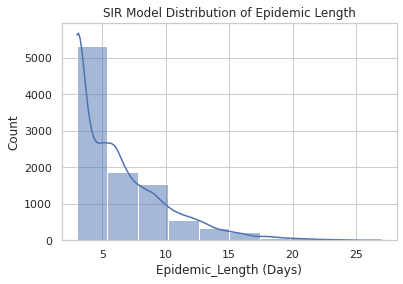

In [87]:
plot_SIR_distribution_epidemic_length(b_df10k)

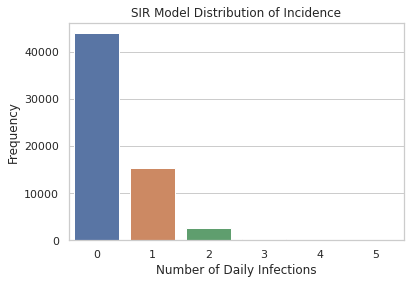

,Number of Daily Infections,Frequency,Percentage
0,0,43990,70.698467
1,1,15379,24.716338
2,2,2553,4.103050
3,3,276,0.443573
4,4,22,0.035357
5,5,2,0.003214


In [88]:
plot_SIR_distribution_incidence(b_dailyinfectionsfreqdf10k)
b_dailyinfectionsfreqdf10k

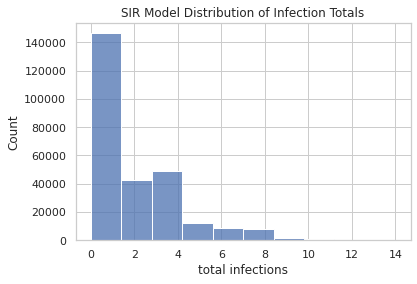

In [89]:
plot_SIR_distribution_infection_totals(b_longdf10k)

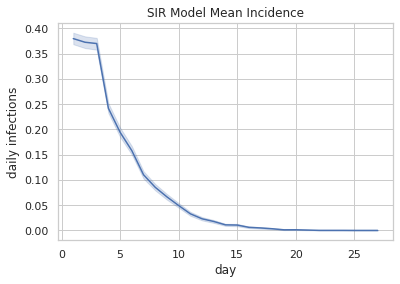

In [90]:
plot_lineplot_epidimiology(b_longdf10k, 
                           x="day", y="daily infections", 
                           title='SIR Model Mean Incidence')

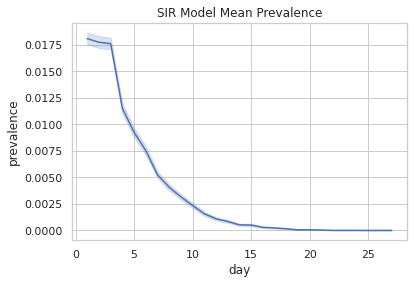

In [91]:
plot_lineplot_epidimiology(b_longdf10k, 
                           x="day", y="prevalence", 
                           title='SIR Model Mean Prevalence')

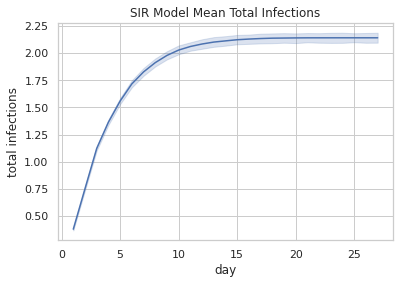

In [92]:
plot_lineplot_epidimiology(b_longdf10k, 
                           x="day", y="total infections", 
                           title='SIR Model Mean Total Infections')

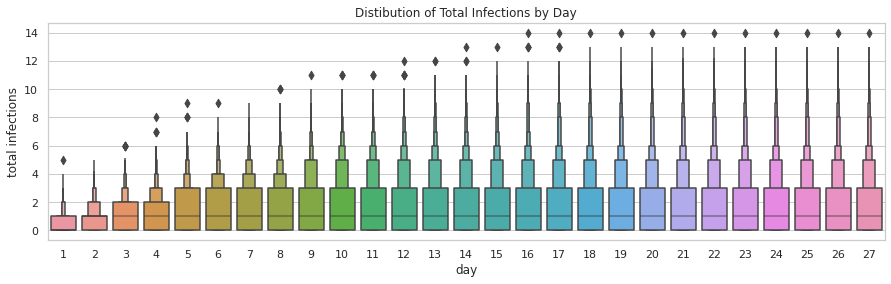

In [93]:
plot_distribution_total_infections_by_day(b_longdf10k)

In [94]:
b_sirdf10k

,simulation,day,variable,value
0,0,1,total infections,0
1,0,2,total infections,0
2,0,3,total infections,1
3,0,4,total infections,3
4,0,5,total infections,4
...,...,...,...,...
809995,9999,23,susceptible,18
809996,9999,24,susceptible,18
809997,9999,25,susceptible,18
809998,9999,26,susceptible,18


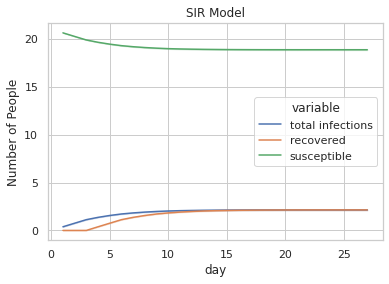

In [95]:
plot_SIR_timeseries(b_sirdf10k)

### Plotting each simulation with dynamic infection probabilities and periods in mind

In [96]:
_,_,b_longdf100,_,_,_ = epidimiological_experiment(
    100, 
    200, 
    (0.05,0.15), 
    (3,7)
)

Total time elapsed to gather data for 100 trials: 0:00:00.635494




<ipython-input-36-69a998a5ed61>:87: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mean_df = long_df.groupby(['day'])['daily infections',


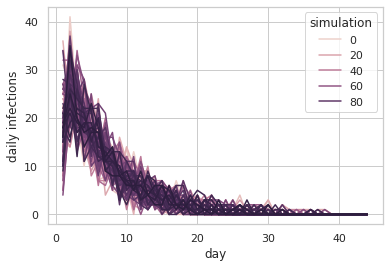

In [97]:
plot_sim_daily_infections(b_longdf100)

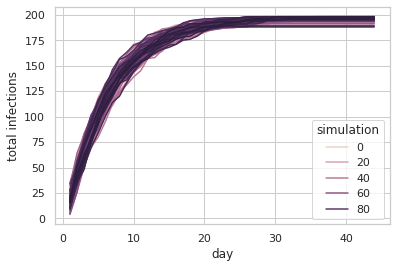

In [98]:
plot_sim_total_infections(b_longdf100)

### Varied Infection probability with dynamic infection periods
$N = 21$, $\text{infection period (days)} \in [3,7)$

In [99]:
p_exposures = [.01, .05, .1, .25, .5, .75]
b_epi_len1, b_prob_dfs = run_variation_analysis(10000, 21, p_exposures, (3,7))

Total time elapsed to gather data for 10000 trials: 0:00:02.285407


Total time elapsed to gather data for 10000 trials: 0:00:07.997547


Total time elapsed to gather data for 10000 trials: 0:00:09.410995


Total time elapsed to gather data for 10000 trials: 0:00:09.944765


Total time elapsed to gather data for 10000 trials: 0:00:08.397984


Total time elapsed to gather data for 10000 trials: 0:00:06.952969




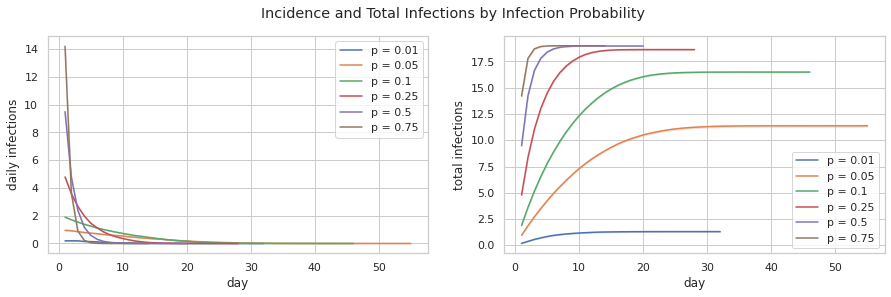

In [100]:
graph_against_infection_counts(p_exposures, 
                               b_prob_dfs,
                               "day",
                               "daily infections",
                               "total infections",
                               'p',
                               'Infection Probability')
#plt.savefig('inf_prob.png')

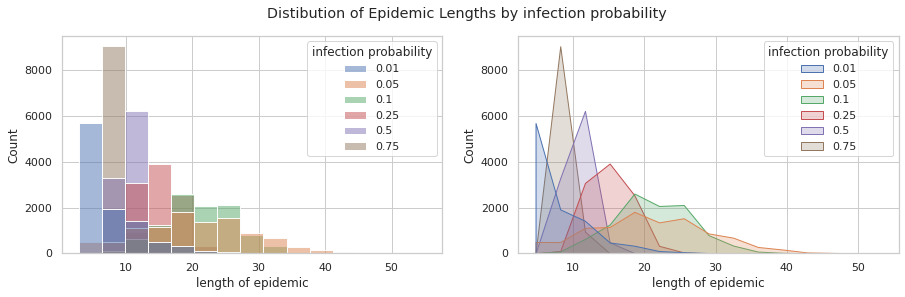

In [101]:
graph_against_epidemic_lengths(b_epi_len1,
                               "length of epidemic",
                               "infection probability",
                               15)
#plt.savefig('inf_prob_epi_len.png')

### Varied Infection Length with Dynamic Infection Probabilities

$N=21$, $p \in(0.05,0.15)$

In [102]:
infection_periods = [1,2,3,4,5]
b_epi_len2, b_l_dfs = run_variation_analysis(10000, 21, (0.05,0.15),
                                             infection_periods)

Total time elapsed to gather data for 10000 trials: 0:00:02.386602


Total time elapsed to gather data for 10000 trials: 0:00:05.217707


Total time elapsed to gather data for 10000 trials: 0:00:07.367591


Total time elapsed to gather data for 10000 trials: 0:00:08.852958


Total time elapsed to gather data for 10000 trials: 0:00:09.987087




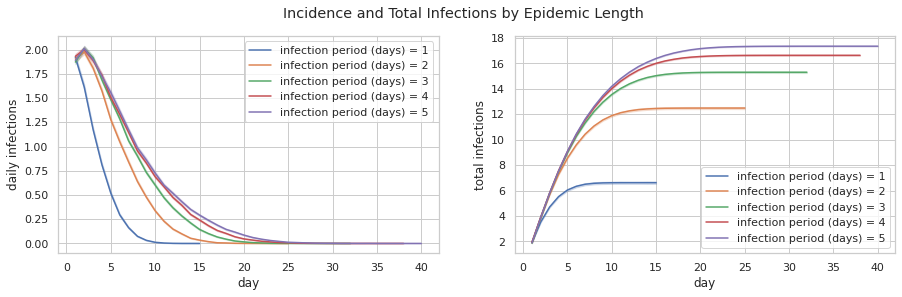

In [103]:
graph_against_infection_counts(infection_periods, 
                               b_l_dfs,
                               "day",
                               "daily infections",
                               "total infections",
                               'infection period (days)',
                               'Epidemic Length')
#plt.savefig('inf_len.png')

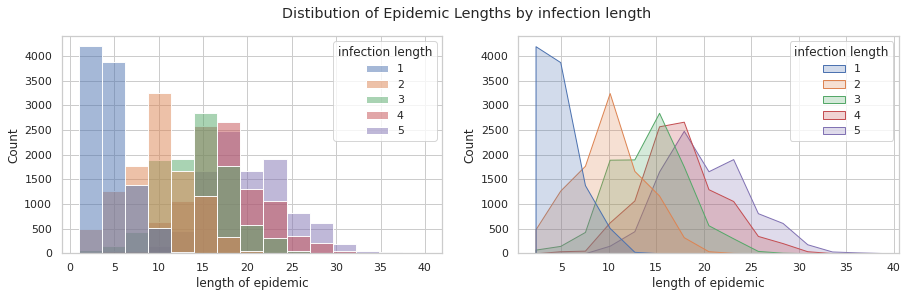

In [104]:
graph_against_epidemic_lengths(b_epi_len2,
                               "length of epidemic",
                               "infection length",
                               15)
#plt.savefig('inf_len_epi_len.png')

### Varied Class Size with Dynamic Infection Periods and Probabilities

$p \in (0.05,0.15)$, $\text{infection period (days)} \in [3,7)$

In [105]:
pop_sizes = [*range(10, 101, 10)]
b_epi_len3, b_c_dfs = run_variation_analysis(10000, pop_sizes, 
                                             (0.05,0.15), (3,7))

Total time elapsed to gather data for 10000 trials: 0:00:05.180726


Total time elapsed to gather data for 10000 trials: 0:00:10.288591


Total time elapsed to gather data for 10000 trials: 0:00:13.995814


Total time elapsed to gather data for 10000 trials: 0:00:17.228042


Total time elapsed to gather data for 10000 trials: 0:00:21.013706


Total time elapsed to gather data for 10000 trials: 0:00:24.161350


Total time elapsed to gather data for 10000 trials: 0:00:27.154319


Total time elapsed to gather data for 10000 trials: 0:00:28.141561


Total time elapsed to gather data for 10000 trials: 0:00:31.010701


Total time elapsed to gather data for 10000 trials: 0:00:33.116024




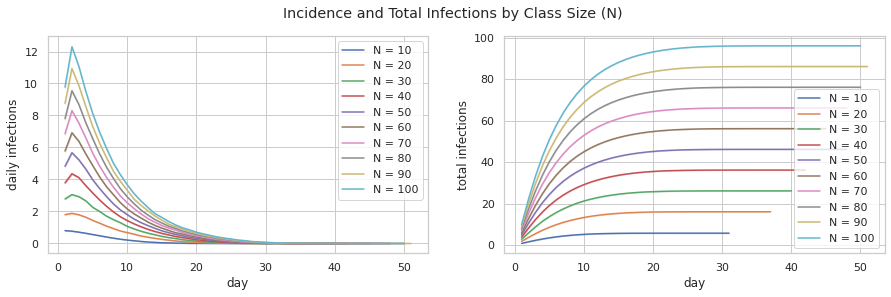

In [106]:
graph_against_infection_counts(pop_sizes, 
                               b_c_dfs,
                               "day",
                               "daily infections",
                               "total infections",
                               'N',
                               "Class Size (N)")
#plt.savefig('class_size.png')

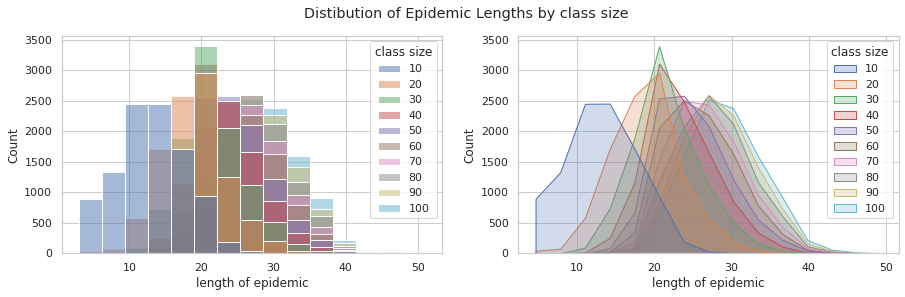

In [107]:
graph_against_epidemic_lengths(b_epi_len3,
                               "length of epidemic",
                               "class size",
                               15)
#plt.savefig('class_size_epi_len.png')